In [1]:
pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 26.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.8 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=f5da70b4c9c1bdbcd14ce6a8ce06413f04d0232989af227320b113d144a4abfd
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1



**Justification:** MIDI handling.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error reading /content/drive/MyDrive/Dataset Music/Msc/Western/Classic/Bomfunk_MCs_-_Uprocking_Beats.mid: MThd not found. Probably not a MIDI file. Skipping...
Error reading /content/drive/MyDrive/Dataset Music/Msc/Western/Classic/Elmer_Bernstein_-_.mid: . Skipping...
Error reading /content/drive/MyDrive/Dataset Music/Msc/Western/Classic/Mahler_Gustav_-_Symphony_#2_(Tenor).mid: data byte must be in range 0..127. Skipping...
Error reading /content/drive/MyDrive/Dataset Music/Msc/Western/Classic/Mahler_Gustav_-_Symphony_#2_(Tenor2).mid: data byte must be in range 0..127. Skipping...
Error reading /content/drive/MyDrive/Dataset Music/Msc/Western/Classic/Unknown_-_pokemon.mid: list index out of range. Skipping...
No valid notes found in /content/drive/MyDrive/Dataset Music/Msc/Western/Classic/Kona_-_Drumloop.mid. Skipping...
No valid notes found in /content/drive/MyDrive/Dataset Music/Msc/Western/Classic/un_debut_au_piano_-_my_first_composition.mid. Skipping...
Error reading /content/drive

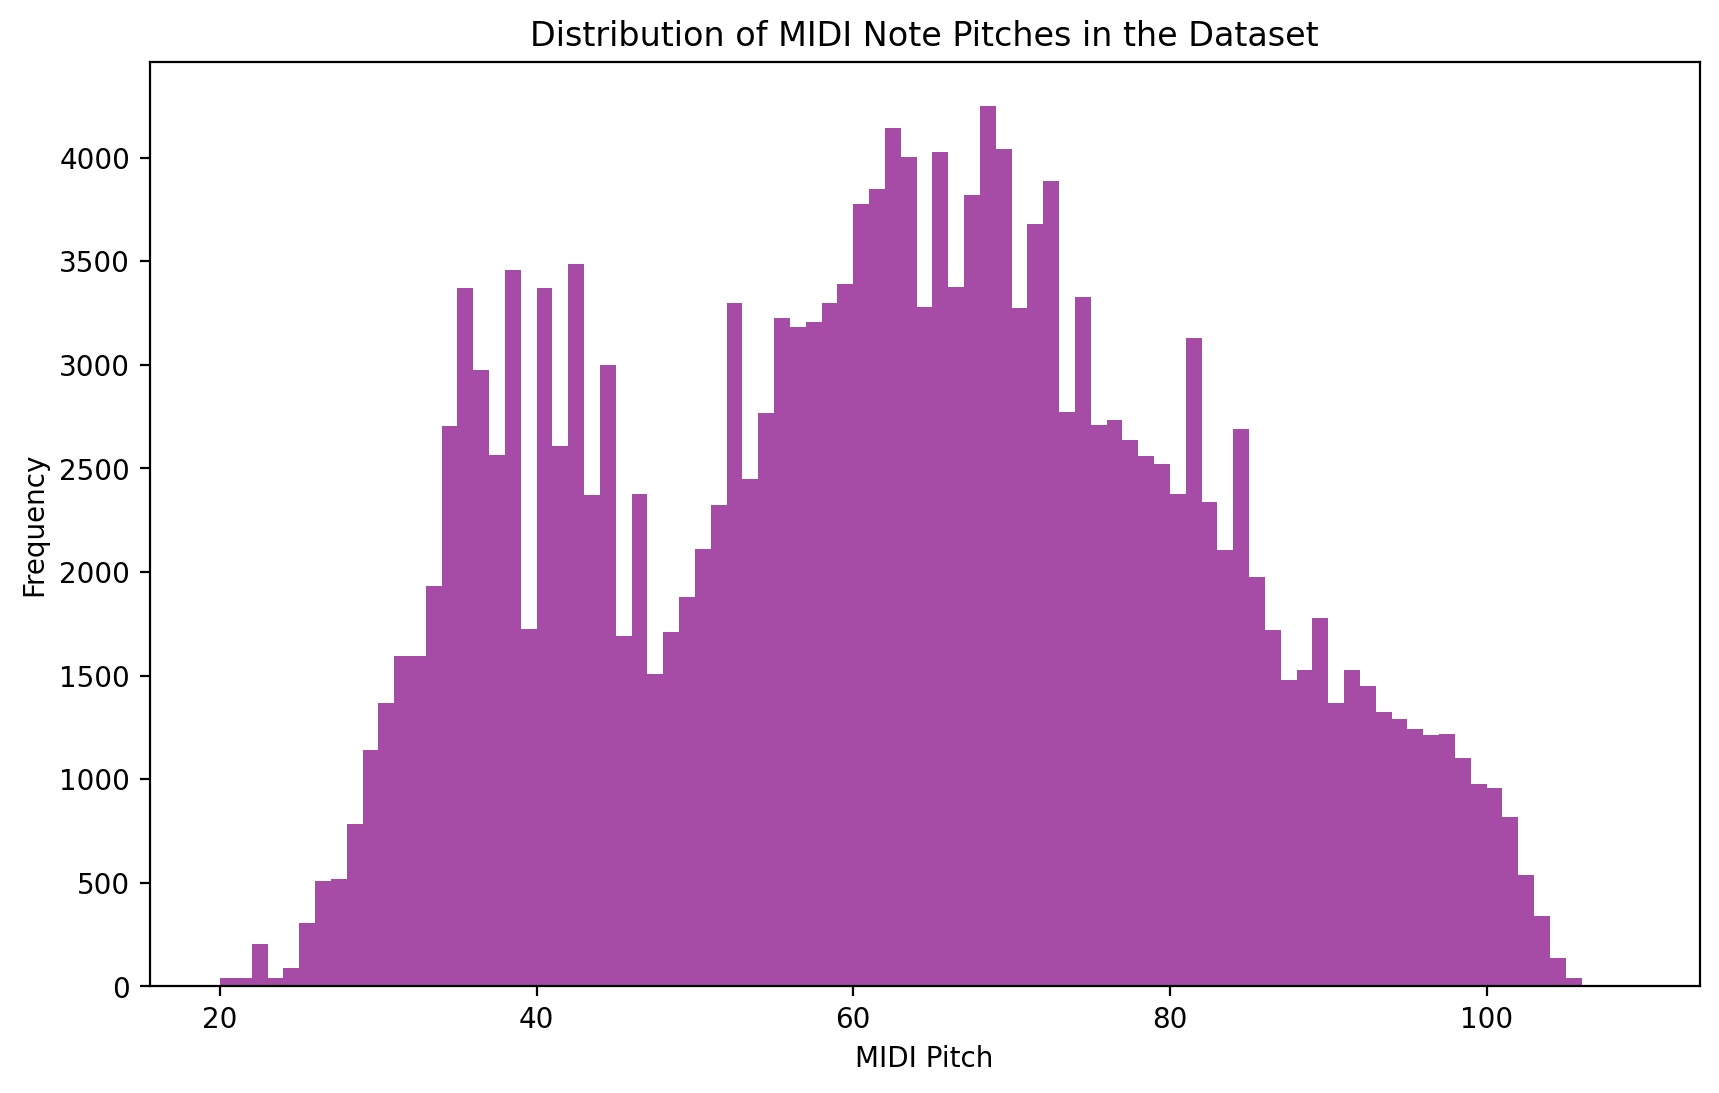

Number of samples in the training set: 307
Number of samples in the validation set: 77


In [2]:
import os
import pretty_midi
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TrainingArguments, DataCollatorForLanguageModeling, Trainer, default_data_collator
import matplotlib.pyplot as plt
import music21
import warnings
import random

# Suppress specific warnings from pretty_midi
warnings.filterwarnings("ignore", category=UserWarning, module='pretty_midi')

# Suppress all warnings from music21
warnings.filterwarnings("ignore", module='music21')

class MIDIDataset(Dataset):
    def __init__(self, root_dirs, tokenizer, max_length=512, augment=False):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.files = []
        for root_dir in root_dirs:
            for subdir, _, files in os.walk(root_dir):
                for file in files:
                    if file.endswith('.midi') or file.endswith('.mid'):
                        self.files.append(os.path.join(subdir, file))

        # Pre-filter the dataset to remove invalid MIDI files
        self.files = self._filter_valid_files(self.files)
        # Calculate total duration
        self.total_duration = self.calculate_total_duration()
        self.augment = augment

        print(f"Loaded {len(self.files)} valid MIDI files.")

    def _filter_valid_files(self, files):
        valid_files = []
        for file in files:
            try:
                midi_data = pretty_midi.PrettyMIDI(file)
                if any(instrument.notes for instrument in midi_data.instruments):
                    valid_files.append(file)
                else:
                    print(f"No valid notes found in {file}. Skipping...")
            except Exception as e:
                print(f"Error reading {file}: {e}. Skipping...")
        return valid_files

    def calculate_total_duration(self):
        total_duration = 0.0
        for file in self.files:
            try:
                score = music21.converter.parse(file)
                total_duration += score.duration.quarterLength
            except Exception as e:
                print(f"Error processing {file}: {e}. Skipping...")
        print(f"Total dataset duration: {total_duration:.2f} quarter lengths")
        return total_duration

    def augment_midi(self, notes):
        # Example augmentation: transpose notes up by a random number of semitones
        transpose = random.choice([-2, -1, 0, 1, 2])
        return [note + transpose for note in notes]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        midi_file = self.files[idx]
        midi_data = pretty_midi.PrettyMIDI(midi_file)

        # Flatten the notes to a simple sequence of pitch values
        notes = []
        for instrument in midi_data.instruments:
            for note in instrument.notes:
                notes.append(note.pitch)

        if self.augment:
            notes = self.augment_midi(notes)

        # Convert the list of notes to a string
        notes_str = " ".join(map(str, notes))

        # Tokenize the notes string
        tokens = self.tokenizer(notes_str, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        return {
            'input_ids': tokens.input_ids.squeeze(0),
            'attention_mask': tokens.attention_mask.squeeze(0)
        }

# Initialize dataset paths
indian_dataset_path = '/content/drive/MyDrive/Dataset Music/Msc/Indian'  # Change to your "Indian" directory
western_dataset_path = '/content/drive/MyDrive/Dataset Music/Msc/Western'  # Change to your "Western" directory

# Initialize tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Set the padding token
tokenizer.pad_token = tokenizer.eos_token

# Load both datasets and filter invalid files with optional augmentation
combined_dataset = MIDIDataset(root_dirs=[indian_dataset_path, western_dataset_path], tokenizer=tokenizer, augment=True)

# Print the total duration of the dataset
print(f"Total duration of the dataset: {combined_dataset.total_duration:.2f} quarter lengths")

# Plot 1: Distribution of MIDI Note Pitches in the Dataset
all_pitches = []
for i in range(len(combined_dataset)):
    item = combined_dataset[i]
    input_ids = item['input_ids'].numpy().tolist()
    pitch_values = tokenizer.decode(input_ids).split()
    all_pitches.extend([int(p) for p in pitch_values if p.isdigit()])

plt.figure(figsize=(10, 6))
plt.hist(all_pitches, bins=range(20, 110), color='purple', alpha=0.7)
plt.xlabel('MIDI Pitch')
plt.ylabel('Frequency')
plt.title('Distribution of MIDI Note Pitches in the Dataset')
plt.show()

# Split the dataset into training and validation sets
train_size = int(0.8 * len(combined_dataset))
val_size = len(combined_dataset) - train_size
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

# Check if the combined dataset is empty and provide more informative error messages
if len(combined_dataset) == 0:
    raise ValueError("The combined dataset is empty. Please check if the directories contain valid MIDI files.")

# Initialize DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=default_data_collator)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=default_data_collator)

# Print the number of samples in the training and validation sets
print(f"Number of samples in the training set: {len(train_dataset)}")
print(f"Number of samples in the validation set: {len(val_dataset)}")

**Justification:** The code prepares a MIDI dataset with optional data augmentation, visualizes the distribution of MIDI note pitches, and splits the data into training and validation sets. This enhances the model's ability to generalize by increasing data variability and provides insights into the dataset's characteristics.

In [3]:
# Step 2: Model Preparation

# Load pre-trained GPT-2 model
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Also set the model's padding token ID to eos token ID
model.config.pad_token_id = model.config.eos_token_id

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

**Justification:** The code loads a pre-trained GPT-2 model and configures it by setting the padding token to the end-of-sequence token, ensuring proper handling of sequences during music generation.

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting training...


Epoch,Training Loss,Validation Loss
1,3.061800,3.074378
2,3.378700,2.973628
3,3.111000,2.955742


/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Training completed.
Evaluating the model...


/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Evaluation results: {'eval_loss': 2.9587278366088867, 'eval_runtime': 256.3119, 'eval_samples_per_second': 0.3, 'eval_steps_per_second': 0.152, 'epoch': 3.0}
Validation Perplexity: 19.2734375
Model saved to ./fine_tuned_gpt2_music_model
Tokenizer saved to ./fine_tuned_gpt2_music_tokenizer


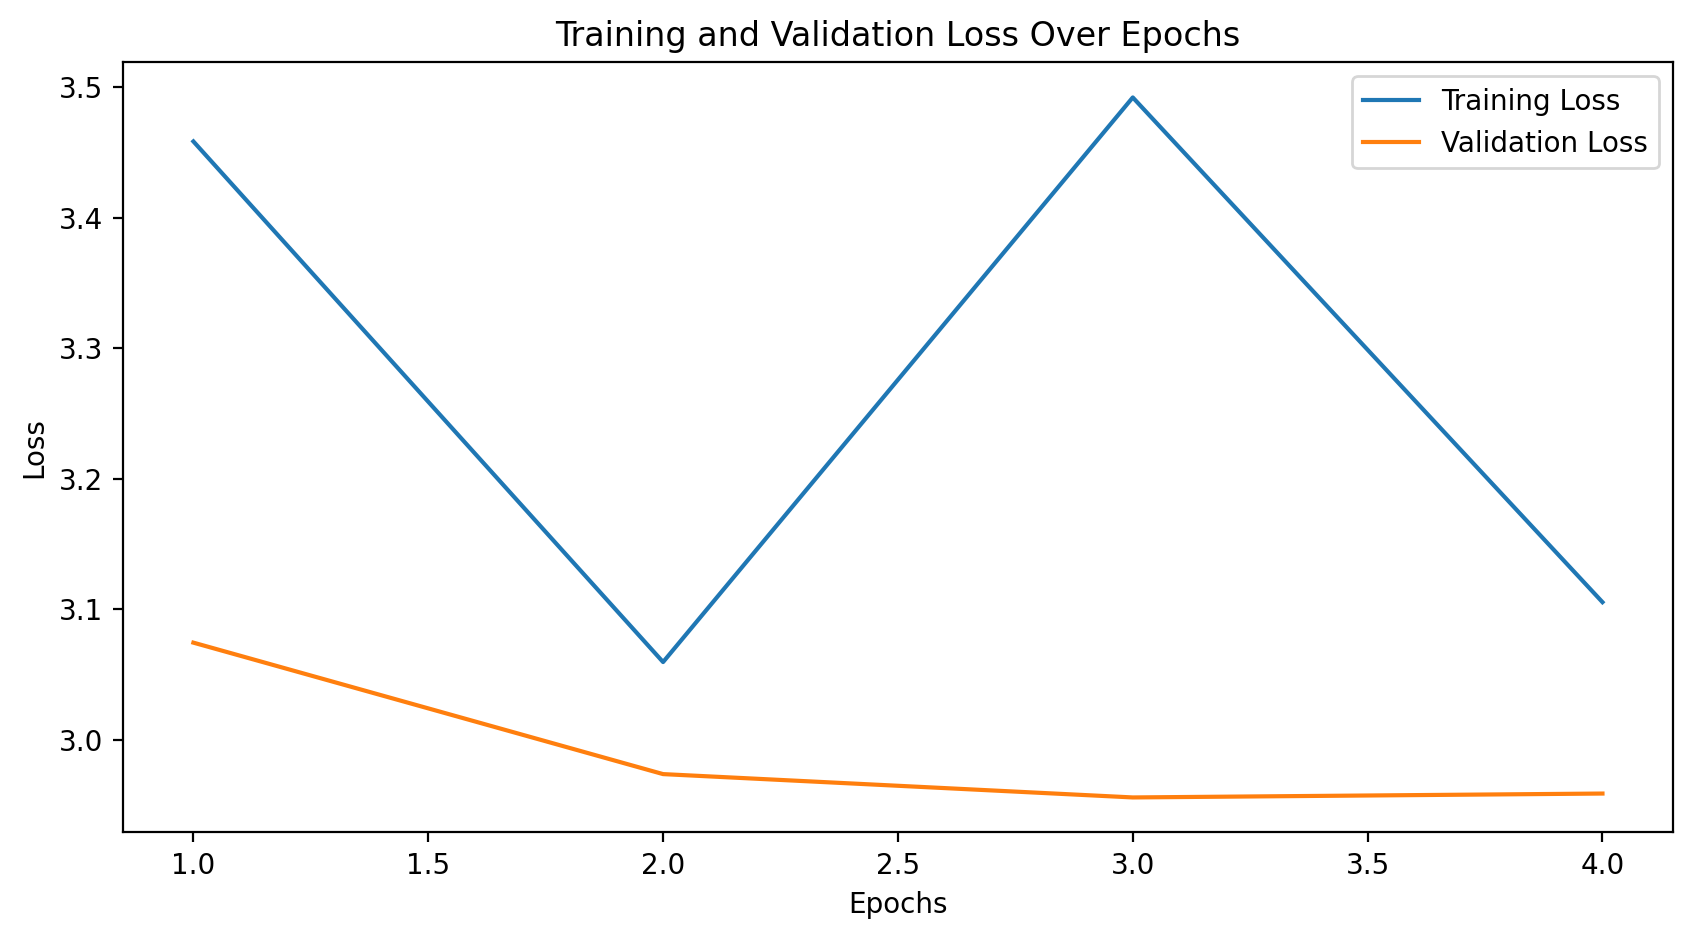

In [4]:
# Step 3: Fine-Tuning the Model (GPT-2)

# Training arguments
train_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",  # Evaluate every epoch
    save_strategy="epoch",  # Save model checkpoint every epoch
    report_to="none"  # Disable automatic logging to W&B or similar tools
)

# Create a data collator for language modeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

# Start training and evaluation
print("Starting training...")
training_history = trainer.train()
print("Training completed.")

# After training, you can evaluate the model on the validation set
print("Evaluating the model...")
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

# Calculate perplexity from the loss
perplexity = torch.exp(torch.tensor(eval_results['eval_loss']))
print(f"Validation Perplexity: {perplexity.item()}")

# Save the trained model and tokenizer
model_save_path = './fine_tuned_gpt2_music_model'
tokenizer_save_path = './fine_tuned_gpt2_music_tokenizer'

model.save_pretrained(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

print(f"Model saved to {model_save_path}")
print(f"Tokenizer saved to {tokenizer_save_path}")

# Extract training and validation losses, averaged per epoch
training_loss = []
validation_loss = []
epochs_logged = []

for log in trainer.state.log_history:
    if 'loss' in log.keys() and 'epoch' in log.keys():
        if log['epoch'] not in epochs_logged:
            training_loss.append(log['loss'])
            epochs_logged.append(log['epoch'])
    if 'eval_loss' in log.keys() and 'epoch' in log.keys():
        if log['epoch'] not in epochs_logged:
            validation_loss.append(log['eval_loss'])

# Ensure both lists have the same length
if len(training_loss) > len(validation_loss):
    training_loss = training_loss[:len(validation_loss)]
elif len(validation_loss) > len(training_loss):
    validation_loss = validation_loss[:len(training_loss)]

# Plot 2: Training and Validation Loss over Epochs
epochs = range(1, len(training_loss) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, label="Training Loss")
plt.plot(epochs, validation_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.show()


**Justification**: The code fine-tunes a GPT-2 model for music generation, tracks training progress, evaluates performance using perplexity, and saves the model. It also plots training and validation losses over epochs to monitor model performance, helping identify potential issues like overfitting.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating music sequence...
Generated MIDI pitch sequence: 50 52 54 55 51 60 57 37 41 46 43 59 58 42 53 67 64 69 34 28 35 31 79 86 73 82 29 88 92 32 93 27 40 66 71 45 50 78 94 80 87 39 84 97 63 96 44 48 76 91 98 74 85 99 83 72 81 36 33 56 103 101 100 89 102 68 105 38 75 90 61 65 70 95 30 49 62 10 26 20 16 9 18 25 17 15 14 24 21 19 23 3 8 4 2 1 5 0 11 77


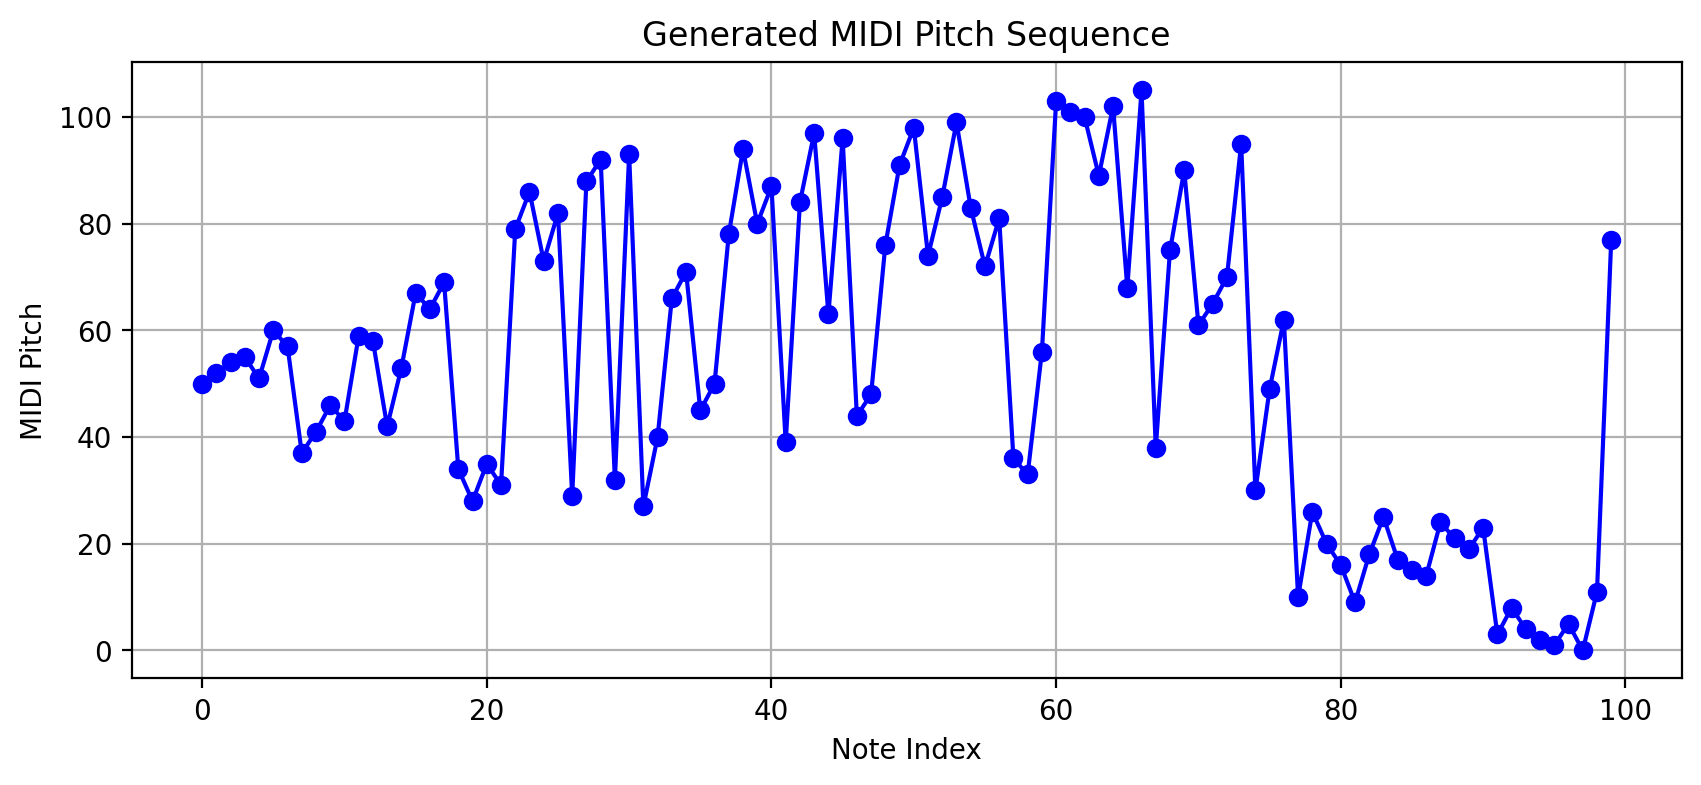

In [5]:
# Step 4: Generate Music Sequence Using the Fine-Tuned GPT-2 Model

# Example prompt for generating music (a simple sequence of note pitches)
input_prompt = "50 52 54 55"  # Example: MIDI pitch values for C, D, E, F
input_ids = tokenizer(input_prompt, return_tensors='pt').input_ids
attention_mask = tokenizer(input_prompt, return_tensors='pt').attention_mask

# Generate sequence using the fine-tuned model with sampling and repetition penalty
print("Generating music sequence...")
output = model.generate(
    input_ids,
    attention_mask=attention_mask,
    max_length=100,
    num_return_sequences=1,
    do_sample=True,  # Enable sampling
    temperature=1.2,  # Increase randomness
    top_k=50,  # Limit the number of choices
    top_p=0.95,  # Use nucleus sampling
    repetition_penalty=2.0  # Penalize repetition
)

# Decode the generated output
output_text = tokenizer.decode(output[0], skip_special_tokens=True)

# Print the generated sequence
print("Generated MIDI pitch sequence:", output_text)

# Plot 4: Visualize Generated MIDI Pitch Sequence
generated_pitches = [int(p) for p in output_text.split()]
plt.figure(figsize=(10, 4))
plt.plot(generated_pitches, marker='o', linestyle='-', color='blue')
plt.xlabel('Note Index')
plt.ylabel('MIDI Pitch')
plt.title('Generated MIDI Pitch Sequence')
plt.grid(True)
plt.show()


**Justification:**The code generates a music sequence using the fine-tuned GPT-2 model from a simple input prompt, decodes the output into a MIDI pitch sequence, and visualizes the sequence with a plot. This process demonstrates the model's ability to create music and provides a visual representation of the generated notes, aiding in understanding the musical output.

In [6]:
# Step 5: Convert the Generated Sequence to a music21 Score

# Convert the generated sequence to a music21 score
def convert_sequence_to_score(sequence):
    notes = sequence.split()
    score = music21.stream.Score()
    part = music21.stream.Part()

    for pitch in notes:
        # Convert pitch from string to integer
        note_pitch = int(pitch)
        # Create a music21 Note object
        note = music21.note.Note(note_pitch)
        note.quarterLength = 0.5  # Set note duration, e.g., half a beat
        part.append(note)

    score.append(part)
    return score

# Example: Add chords to the score
def add_chords_to_score(score):
    chords = [
        music21.chord.Chord(['C4', 'E4', 'G4']),
        music21.chord.Chord(['F4', 'A4', 'C5']),
        music21.chord.Chord(['G4', 'B4', 'D5']),
        music21.chord.Chord(['C4', 'E4', 'G4'])
    ]

    for chord in chords:
        chord.quarterLength = 2  # Each chord lasts for two beats
        score.insert(chord.offset, chord)

    return score

# Example: Add lyrics to the score
def add_lyrics_to_score(score, lyrics):
    part = score.parts[0]
    for i, note in enumerate(part.notes):
        if i < len(lyrics):
            note.lyric = lyrics[i]

    return score

# Convert the generated sequence to a score
print("Converting sequence to music21 score...")
score = convert_sequence_to_score(output_text)

# Optionally, add chords and lyrics
score = add_chords_to_score(score)
lyrics = "This is a test of generated music".split()
score = add_lyrics_to_score(score, lyrics)

Converting sequence to music21 score...


**Justification:** The code converts the generated MIDI pitch sequence into a music21 score, enabling further musical structuring and notation. It optionally enhances the score by adding chords and lyrics, transforming the sequence into a complete and performable piece of music. This step bridges the gap between raw generated data and a structured musical composition.

In [7]:
# Step 6: Save the Generated Score as a MIDI File

# Function to save the score as a MIDI file
def save_score_as_midi(score, output_midi_file='generated_music21.mid'):
    mf = music21.midi.translate.music21ObjectToMidiFile(score)
    mf.open(output_midi_file, 'wb')
    mf.write()
    mf.close()
    print(f"Saved MIDI file to {output_midi_file}")

# Save the generated score as a MIDI file
output_midi_path = '/content/drive/MyDrive/Dataset Music/Msc/generated_music21.mid'
save_score_as_midi(score, output_midi_path)

Saved MIDI file to /content/drive/MyDrive/Dataset Music/Msc/generated_music21.mid



**Justification:** The code saves the generated music21 score as a MIDI file, allowing for easy playback, sharing, and further manipulation in digital audio workstations. This step finalizes the music generation process by creating a tangible output that can be used in various musical applications.

In [8]:
# Step 7: Play Original MIDI Files for Comparison

# Function to load and play a MIDI file
def load_and_play_midi(midi_file_path):
    try:
        # Load the MIDI file
        score = music21.converter.parse(midi_file_path)

        # Show and play the MIDI file
        score.show('midi')
        print(f"Playing {midi_file_path}...")
    except Exception as e:
        print(f"Error loading or playing {midi_file_path}: {e}")

# Example usage with an Indian MIDI file
indian_midi_path = '/content/drive/MyDrive/Dataset Music/Msc/Indian/SemiClassical/-211878.mp3.mid'  # Replace with an actual file path
load_and_play_midi(indian_midi_path)

# Example usage with a Western MIDI file
western_midi_path = '/content/drive/MyDrive/Dataset Music/Msc/Western/pop/Babyface_-_When_Can_I_See_You_Again.mid'  # Replace with an actual file path
load_and_play_midi(western_midi_path)

Playing /content/drive/MyDrive/Dataset Music/Msc/Indian/SemiClassical/-211878.mp3.mid...


Playing /content/drive/MyDrive/Dataset Music/Msc/Western/pop/Babyface_-_When_Can_I_See_You_Again.mid...


**Justification:**The code loads and plays original MIDI files using music21, allowing for auditory comparison between the original music and the generated sequences. This step is essential for evaluating the quality and characteristics of the generated music in the context of the original datasets, providing insight into how well the model has captured the musical styles.

In [9]:
# Step 8: Trim and Play MIDI Files

# Function to trim the MIDI file to a specific duration (in seconds)
def trim_midi_to_duration(midi_file_path, duration_sec):
    # Load the MIDI file with pretty_midi
    midi_data = pretty_midi.PrettyMIDI(midi_file_path)

    # Create a new PrettyMIDI object to store the trimmed data
    trimmed_midi = pretty_midi.PrettyMIDI()

    for instrument in midi_data.instruments:
        new_instrument = pretty_midi.Instrument(program=instrument.program, is_drum=instrument.is_drum)
        for note in instrument.notes:
            if note.start < duration_sec:
                new_note = pretty_midi.Note(velocity=note.velocity,
                                            pitch=note.pitch,
                                            start=note.start,
                                            end=min(note.end, duration_sec))
                new_instrument.notes.append(new_note)
        trimmed_midi.instruments.append(new_instrument)

    # Save the trimmed MIDI file
    trimmed_midi_path = midi_file_path.replace(".mid", "_trimmed.mid")
    trimmed_midi.write(trimmed_midi_path)

    return trimmed_midi_path

# Function to load and play a MIDI file (after trimming to 30 seconds)
def load_and_play_midi(midi_file_path, duration_sec=30):
    try:
        # Trim the MIDI file to the specified duration
        trimmed_midi_path = trim_midi_to_duration(midi_file_path, duration_sec)

        # Load the trimmed MIDI file
        score = music21.converter.parse(trimmed_midi_path)

        # Show and play the trimmed MIDI file
        score.show('midi')
        print(f"Playing {trimmed_midi_path} (trimmed to {duration_sec} seconds)...")
    except Exception as e:
        print(f"Error loading or playing {midi_file_path}: {e}")

# Example usage with an Indian MIDI file
load_and_play_midi(indian_midi_path)

# Example usage with a Western MIDI file
load_and_play_midi(western_midi_path)

Playing /content/drive/MyDrive/Dataset Music/Msc/Indian/SemiClassical/-211878.mp3_trimmed.mid (trimmed to 30 seconds)...


Playing /content/drive/MyDrive/Dataset Music/Msc/Western/pop/Babyface_-_When_Can_I_See_You_Again_trimmed.mid (trimmed to 30 seconds)...


**Justification:** The code trims MIDI files to a specified duration (e.g., 30 seconds) and plays them using music21. This allows for quick, focused comparisons of key sections of the original music, making it easier to analyze and compare shorter segments of MIDI files.

In [10]:
# Step 9: Play the Generated MIDI File

# Function to play the MIDI file using music21
def play_midi(midi_file_path):
    try:
        # Load the MIDI file
        score = music21.converter.parse(midi_file_path)

        # Play the MIDI file
        score.show('midi')
        print(f"Playing {midi_file_path}...")
    except Exception as e:
        print(f"Error playing {midi_file_path}: {e}")

# Example usage with the generated MIDI file
play_midi(output_midi_path)

Playing /content/drive/MyDrive/Dataset Music/Msc/generated_music21.mid...


**Justification:** The code plays the generated MIDI file using music21, allowing for an immediate auditory review of the output produced by the model. This final step provides a direct way to evaluate the quality and musicality of the generated sequence, completing the music generation process.